In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Mobility into San Diego is dominated by nearby locations
Estimated weekly travel counts into San Diego show both the magnitude and temporal dynamics of travel into San Diego during the pandemic.

We first load mobility data from SafeGraph that has been prepared as in Zeller et al. 2020. We noticed that travel from internation locations increased uniformly from 2019 to 2020, but that increase wasn't consistent with independent mobility data sources. To correct this artifact, we normalized mobility data for each location from January 1st, 2020 onward by multiplying it by the ratio of the mean mobility between January 1st and March 1st in 2019 compared to 2020.

For ease of viewing, we sort the mobility matrix by each locations total amount of travellers into San Diego from 2020 onwards.

In [2]:
def correct_mobility( entry ):
    start = "2019-03-01"
    end = "2019-12-29"

    return_df = entry.copy()
    mean2019 = entry.loc[entry["date_range_start"] < start,"true_visitor_count"].mean()
    mean2020 = entry.loc[entry["date_range_start"].between( end, "2020-03-01"),"true_visitor_count"].mean()
    ratio = mean2019 / mean2020


    return_df["corrected_visitor_count"] = return_df["true_visitor_count"]
    if (mean2019 == 0) or (mean2020 == 0):
        return return_df

    return_df.loc[entry["date_range_start"] > end, "corrected_visitor_count"] = return_df["true_visitor_count"] * ratio
    return return_df

st = pd.read_csv( "../data/mobility_states.csv", parse_dates=["date_range_start"] )
st = st.drop( columns=["California"] )
st = st.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

cr = pd.read_csv("../data/mobility_countries.csv", parse_dates=["date_range_start"] )
cr = cr.drop( columns=["Georgia", "United States"] )
cr = cr.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

ca = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"] )
ca = ca.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

mob = pd.concat( [st, cr, ca] )
mob = mob.groupby( "location" ).apply( correct_mobility ).reset_index( drop=True )

# Run diagnostics on unaltered DataFrame
diagnostic_df = mob.copy()

mob_mat = mob.pivot( index="date_range_start", columns="location", values="corrected_visitor_count" )
mobility_order = mob_mat.loc[mob_mat.index > "2019-12-29"].sum().sort_values( ascending=False ).index
mob_mat = mob_mat.reindex( columns=mobility_order )
mob_mat.head()

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_6865/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_6865/3161503558.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = mean2019 / mean2020


location,Riverside County,Los Angeles County,Orange County,Arizona,Mexico,San Bernardino County,Texas,Nevada,Florida,Washington,...,South Sudan,Faroe Islands,Sierra Leone,Seychelles,Guinea,Jersey,Kyrgyzstan,"Micronesia, Federated States of",Mozambique,Zimbabwe
date_range_start,,,,,,,,,,,,,,,,,,,,,
2019-01-07,77863.266,49388.780,37412.844,16813.560608,44991.330,16307.298,20813.039544,9756.815551,9216.801453,9081.798273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-14,76360.086,50436.355,37120.996,20107.565341,41104.812,17325.422,21653.199559,9803.332422,10298.507941,10455.933639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-21,83053.740,58511.790,43033.832,19319.667557,41168.895,18466.880,20264.123175,9080.660832,10416.787259,10139.006277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-28,75782.560,44737.848,31237.934,14926.174372,45540.637,15490.577,16550.740375,6602.499615,9866.885271,5781.318538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-02-04,77509.266,53122.640,36445.625,17898.672831,46502.164,17854.766,16945.627435,7756.091690,10452.515394,8200.330026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.802998


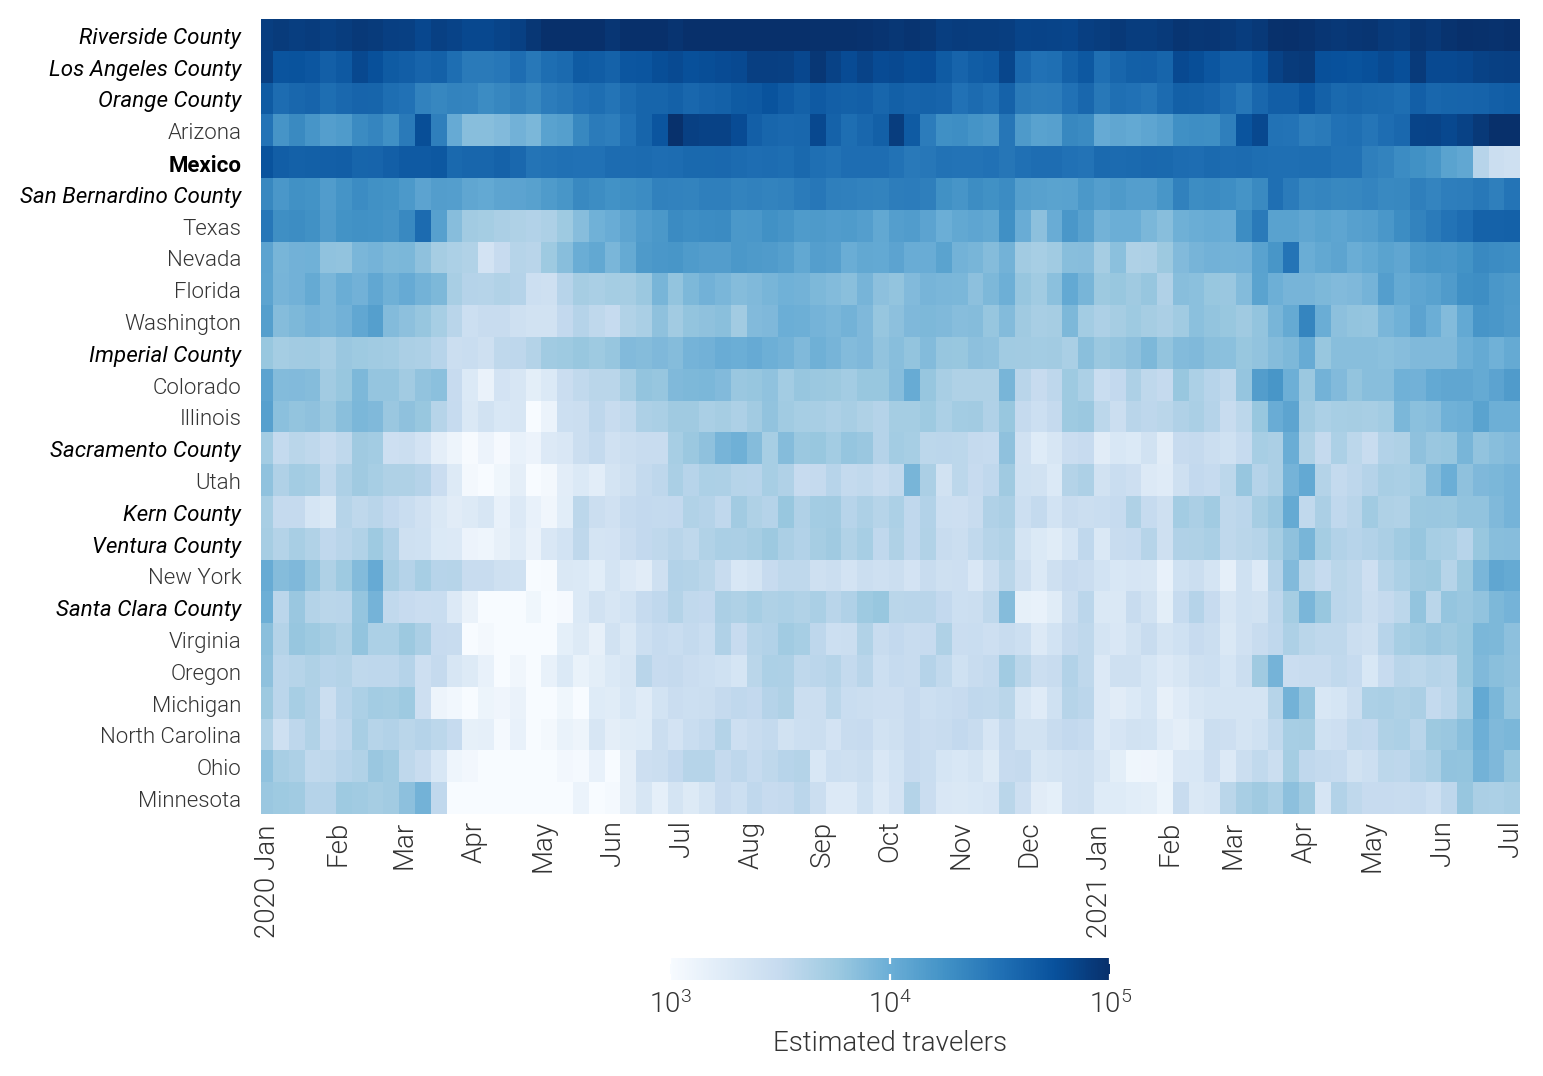

In [4]:
def plot_mobility( df, ax, top=25, log=True, date_range=None, highlights=[], vmin=1000, vmax=1e7, xsize=10, ysize=8, labelsize=10, shrink=0.35, pad=0.13 ):

    plot_df = df.copy()
    plot_df.index = mdates.date2num( plot_df.index )
    plot_df = plot_df.iloc[:,:top]

    if log:
        f1 = ax.imshow( plot_df.T, aspect="auto",
                        norm=LogNorm(vmin=vmin, vmax=vmax ),
                        cmap="Blues", interpolation="nearest",
                        extent=[plot_df.index.min(), plot_df.index.max(), 0, plot_df.shape[1]] )
    else:
        f1 = ax.imshow( plot_df.T, aspect="auto",
                    cmap="Blues", interpolation="nearest",
                    extent=[plot_df.index.min(), plot_df.index.max(), 0, plot_df.shape[1]] )

    ax.set_yticks( np.arange( 0.5, plot_df.shape[1] + 0.5) )
    ax.set_yticklabels( plot_df.columns[::-1] )
    #ax.set_yticks( np.arange(0, plot_df.shape[1]), minor=True)
    #ax.grid( which="minor", axis="y", color="w", linestyle='-', linewidth=1, zorder=5 )

    if date_range is None:
        ax.set_xlim( pd.to_datetime( "2019-12-29" ), pd.to_datetime( "2021-07-05" ) )
    else:
        ax.set_xlim( *date_range )

    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=xsize, pad=0.01 )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )

    [ax.spines[j].set_visible(False) for j in ax.spines]

    cbar = plt.colorbar( f1, ax=ax, orientation="horizontal", shrink=shrink, pad=pad, ticks=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])#, format=lambda x,y: f"{x:.0%}" )
    cbar.outline.set_visible( False )
    #cbar.ax.set_ylabel( "Estimated number\n of travelers", fontsize=10, labelpad=100, rotation=0, ha="left", va="center" )
    cbar.set_label( "Estimated travelers", fontsize=labelsize )
    cbar.ax.tick_params( labelsize=labelsize, size=2, top=True, bottom=True, color="w", direction="in" )
    cbar.ax.minorticks_off()

    if len( highlights ) > 0:
        for i in ax.get_yticklabels():
            if i.get_text() in highlights:
                i.set_fontweight( "bold" )
                i.set_color( "black" )
            if i.get_text().endswith( "County" ):
                i.set_fontstyle( "italic" )
                i.set_fontweight( "normal" )
                i.set_color( "black" )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_mobility( mob_mat, ax, highlights=cr["location"].unique(), vmax=1e5 )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_mobility-into-san-diego-matrix.pdf" )
plt.show()

We observe increased mobility into San Diego on the week of Thanksgiving, Christmas, and Spring break. We quantify the percent increase in travel during these weeks relative to the previous week.

In [16]:
thanksgiving = mob_mat.loc["2020-11-23"].sum() / mob_mat.loc["2020-11-16"].sum()
print( f"Thanksgiving: {thanksgiving-1:.1%}" )

christmas = mob_mat.loc["2020-12-21"].sum() / mob_mat.loc["2020-12-14"].sum()
print( f"Christmas: {christmas-1:.1%}" )

spring_break = mob_mat.loc[["2021-03-15", "2021-03-22", "2021-03-29", "2021-04-05"]].sum().sum() / mob_mat.loc[["2021-02-15", "2021-02-22", "2021-03-01", "2021-03-08"]].sum().sum()
print( f"Spring-break: {spring_break-1:.1%}" )

Thanksgiving: 29.0%
Christmas: 22.2%
Spring-break: 40.2%


In [18]:
cumulative_percentage = mob_mat.loc[mob_mat.index > "2019-12-31"].sum()
cumulative_percentage = cumulative_percentage.cumsum() / cumulative_percentage.sum()
cumulative_percentage.head(50)

location
Riverside County         0.199556
Los Angeles County       0.322454
Orange County            0.404985
Arizona                  0.486895
Mexico                   0.558770
San Bernardino County    0.603936
Texas                    0.639974
Nevada                   0.664252
Florida                  0.683474
Washington               0.700719
Imperial County          0.716381
Colorado                 0.731161
Illinois                 0.743356
Sacramento County        0.752925
Utah                     0.762293
Kern County              0.771310
Ventura County           0.780190
New York                 0.788843
Santa Clara County       0.797397
Virginia                 0.805489
Oregon                   0.813125
Michigan                 0.820493
North Carolina           0.827874
Ohio                     0.834820
Minnesota                0.841662
Georgia                  0.848483
Contra Costa County      0.855201
Pennsylvania             0.861501
Alameda County           0.867499
Misso

We noticed that the top 5 locations appeared to be less variable than all other locations. Particular during the general decrease in mobility during March.

In [19]:
february = mob_mat.loc[["2020-02-03", "2020-02-10", "2020-02-17", "2020-02-24"]]
march = mob_mat.loc[["2020-03-02" ,"2020-03-09" ,"2020-03-16" ,"2020-03-23"]]

print( f"Top 5 locations: {1 - (march.iloc[:,:5].sum().sum() / february.iloc[:,:5].sum().sum()):.1%}" )
print( f"All other locations: {1 - (march.iloc[:,5:].sum().sum() / february.iloc[:,5:].sum().sum()):.1%}" )

Top 5 locations: 8.9%
All other locations: 25.0%


# Diagnostic plots
We confirm the presence of an artifact in the international mobility data, beginning on the week encompassing January 1st, 2020.

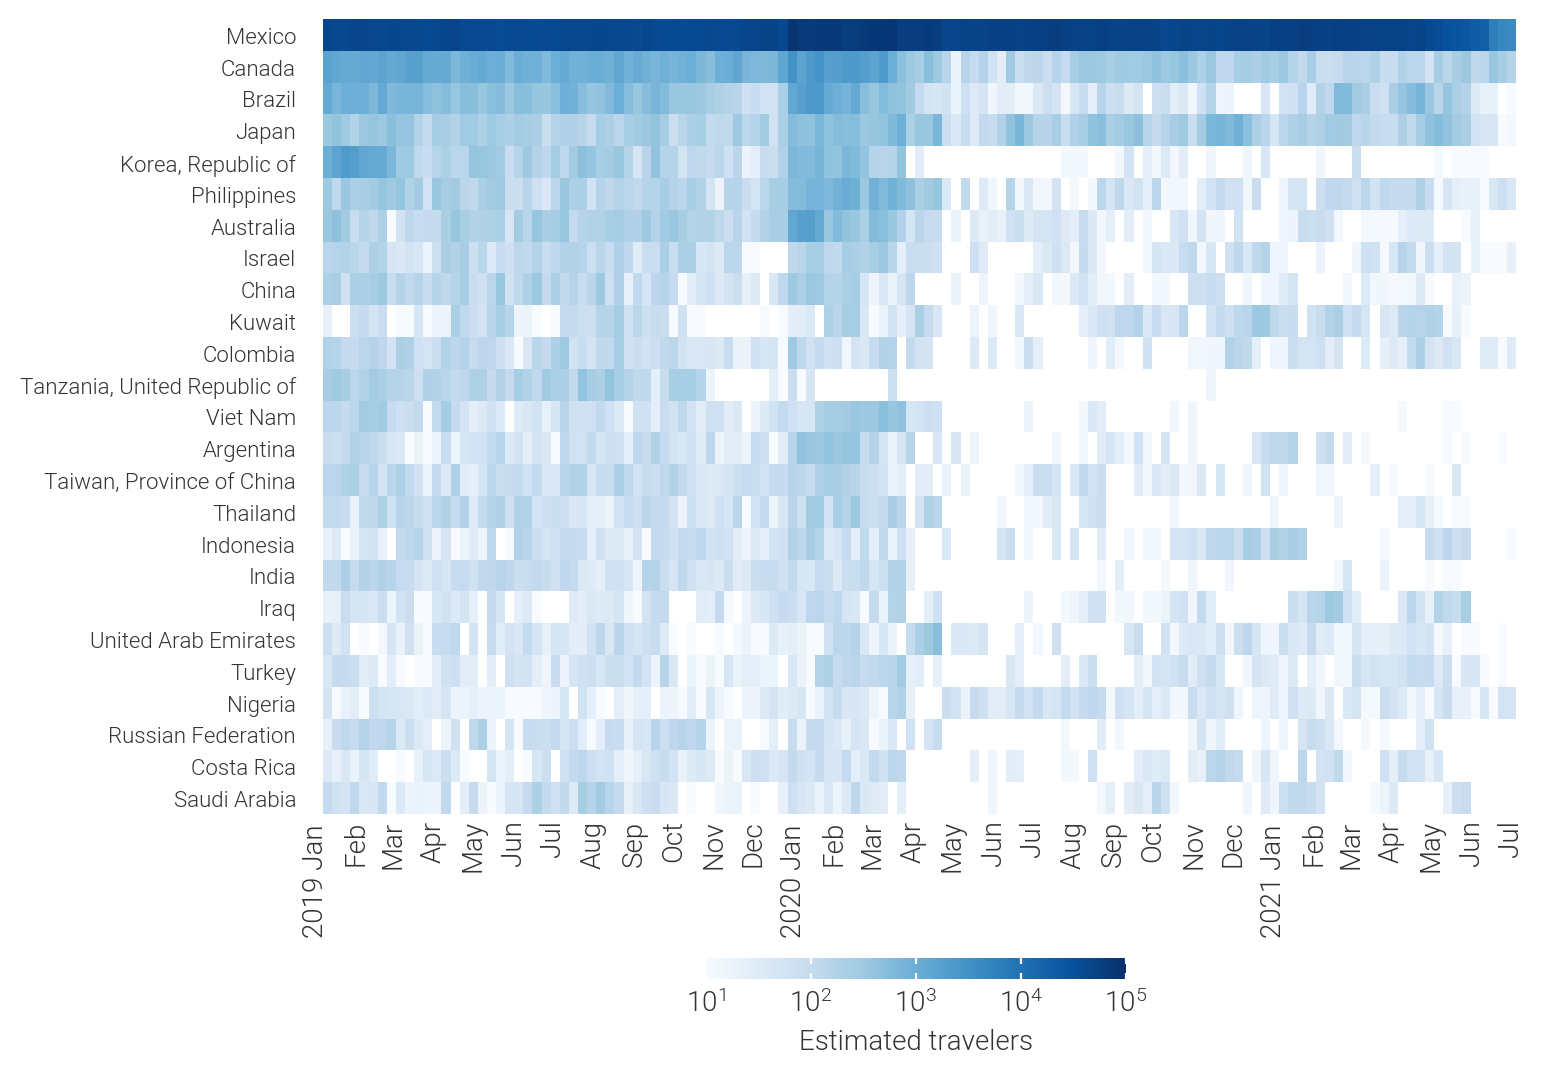

In [27]:
plot_df = cr.pivot( index="date_range_start", columns="location", values="true_visitor_count" )
plot_df = plot_df.reindex( columns=plot_df.sum().sort_values( ascending=False ).index )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_mobility( plot_df, ax, highlights=[], vmax=1e5, vmin=1e1 )
ax.set_xlim( pd.to_datetime( "2019-01-01" ) )
plt.tight_layout()
plt.show()

We assess how correcting the artifact effects the ranking of locations' mobility to San Diego. For the 25 locations with the most mobility into San Diego, we plot the log difference between the corrected and uncorrected visitor counts (positive values indicate decrease in travellers estimates due to correction).

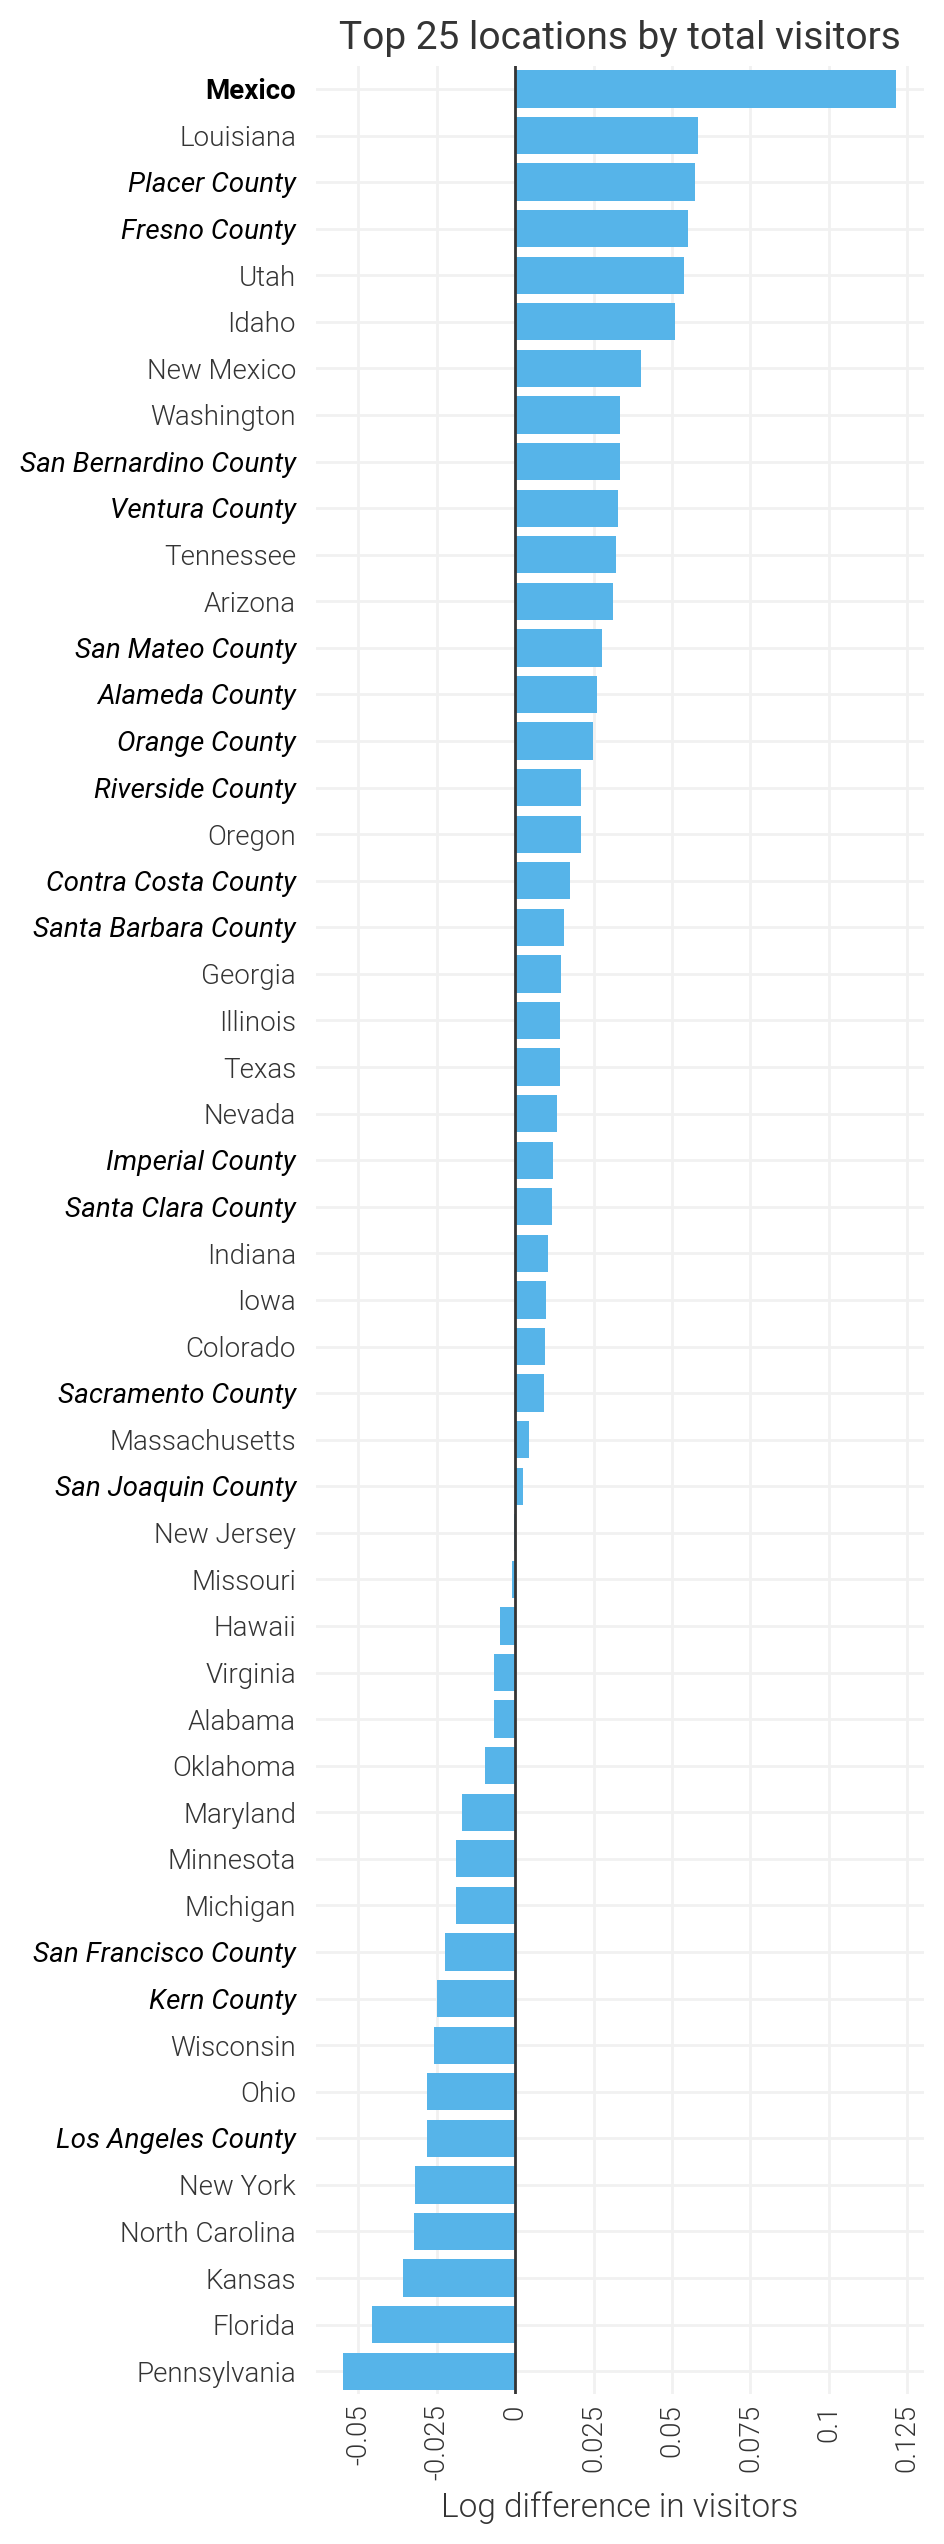

In [30]:
def total_diff( entry ):
    return entry["true_visitor_count"].sum() - entry["corrected_visitor_count"].sum()

def log_diff( entry ):
    return np.log10( entry["true_visitor_count"].sum() ) - np.log10( entry["corrected_visitor_count"].sum() )

temp = pd.merge( diagnostic_df.groupby( "location" ).apply( total_diff ).reset_index( name='total_diff' ), diagnostic_df.groupby( "location" ).apply( log_diff ).reset_index( name='log_diff' ) )
plot_df = temp.loc[temp["location"].isin( (diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby("location")["true_visitor_count"].sum()).sort_values( ascending=False ).head(50).index  )].sort_values( "log_diff" )
fig, ax = plt.subplots( dpi=200, figsize=(5,13))
ax.barh( y="location", width="log_diff", data=plot_df, zorder=10, color="#56B4E9" )
ax.set_xlabel( "Log difference in visitors", fontsize=12 )
ax.set_ylim( -0.5, 49.5 )
ax.set_xticks( [-0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125] )
ax.set_xticklabels( [-0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125] )

ax.set_yticks( np.arange( 0, plot_df.shape[0]) )
ax.set_yticklabels( plot_df["location"] )

for i in ax.get_yticklabels():
    if i.get_text() in ["Mexico"]:
        i.set_fontweight( "bold" )
        i.set_color( "black" )
    if i.get_text().endswith( "County" ):
        i.set_fontstyle( "italic" )
        i.set_fontweight( "normal" )
        i.set_color( "black" )

ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=10, pad=0.01 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10 )

[ax.spines[j].set_visible(False) for j in ax.spines]
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1  )
ax.axvline( 0, color=COLOR, zorder=11, linewidth=1 )
ax.set_title( "Top 25 locations by total visitors", fontsize=14 )

plt.tight_layout()
#plt.savefig( "../figures/mobility_correction_diff.pdf" )
plt.show()

We next assessed the impact correcting the artifact had on the ranking of locations. In this plot, higher rank indicates greater travel into San Diego.

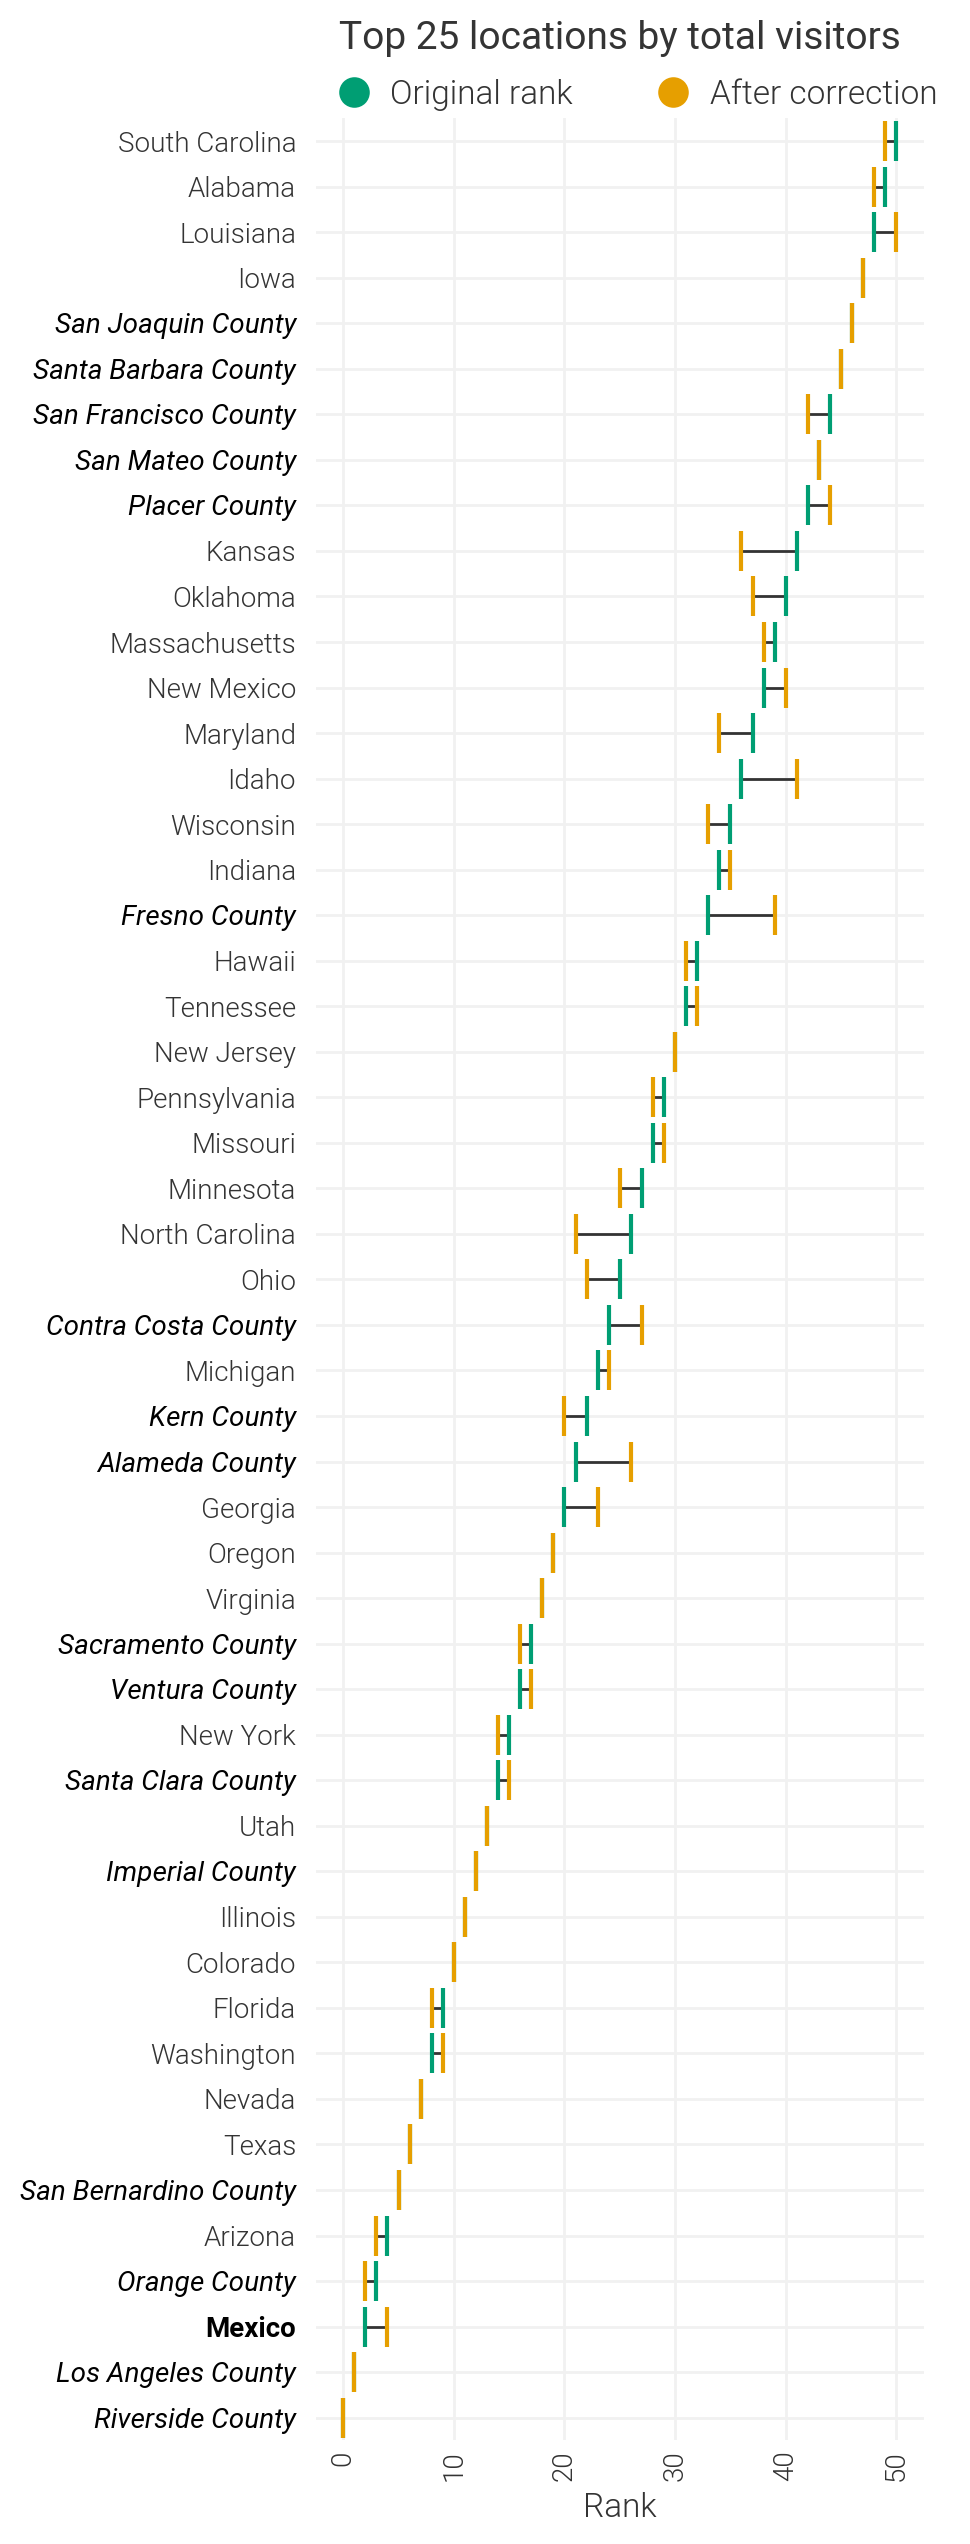

In [31]:
original_order = diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby( "location" )["true_visitor_count"].sum().sort_values( ascending=False )
original_order = original_order.reset_index().reset_index().set_index( "location" )
original_order = original_order.rename( columns={"index" : "original_order" } )
new_order = diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby( "location" )["corrected_visitor_count"].sum().sort_values( ascending=False )
new_order = new_order.reset_index().reset_index().set_index( "location" )
new_order = new_order.rename( columns={"index" : "corrected_order" } )

plot_df = pd.merge( original_order, new_order, left_index=True, right_index=True  ).reset_index()
plot_df = plot_df.loc[plot_df["original_order"] < 51]
fig, ax = plt.subplots( dpi=200, figsize=(5,13))
ax.scatter( y="location", x="original_order", data=plot_df, zorder=10, s=200, marker="|", color="#009E73" )
ax.scatter( y="location", x="corrected_order", data=plot_df, zorder=11, s=200, marker="|", color="#E69F00" )
ax.hlines( y="location", xmin="original_order", xmax="corrected_order", data=plot_df, linewidth=1, color=COLOR )

ax.set_xlabel( "Rank", fontsize=12 )
ax.set_yticks( np.arange( 0, plot_df.shape[0]) )
ax.set_yticklabels( plot_df["location"] )
ax.set_ylim( -0.5, 50.5 )

for i in ax.get_yticklabels():
    if i.get_text() in ["Mexico"]:
        i.set_fontweight( "bold" )
        i.set_color( "black" )
    if i.get_text().endswith( "County" ):
        i.set_fontstyle( "italic" )
        i.set_fontweight( "normal" )
        i.set_color( "black" )

ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=10, pad=0.01 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10 )

[ax.spines[j].set_visible(False) for j in ax.spines]
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1  )
ax.set_title( "Top 25 locations by total visitors", fontsize=14, pad=25 )

legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Original rank", markersize=10 ),
          Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="After correction", markersize=10 )]
ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=12, bbox_to_anchor=(0,0,1.03,1.03), ncol=2 )


plt.tight_layout()
#plt.savefig( "../figures/mobility_correction_rank.pdf" )
plt.show()